In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import statsmodels.api as sm
import scipy.stats as stats

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)


## Compare wind gusts

In [2]:
# Load data from MED-R Preindustrial and increased
directory_exp = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/'

experiments = ['incr', 'pi']
cfpf = ['cf', 'pf']  # control and perturbed are treated equally
members = {'pi' : ['b2nn_2022-02-14', 'b2ns_2022-02-16', 'b2nq_2022-02-10'], 
           'incr' : ['b2no_2022-02-14', 'b2nr_2022-02-10', 'b2nt_2022-02-16']}  # members for incr and pi runs

wind_gusts_pi = []
wind_gusts_incr = []

for experiment in experiments:
    for cont in cfpf:
        for member in members[experiment]:
            if experiment == 'pi':
                wind_gusts_pi.extend(list(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,member+'.nc')).fg10.values.flatten()))
            elif experiment == 'incr':
                wind_gusts_incr.extend(list(xr.open_dataset(os.path.join(directory_exp,experiment,'EU025/sfc',cont,member+'.nc')).fg10.values.flatten()))


In [3]:
# Load data from current climate
directory_ens = '/network/group/aopp/predict/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/'
dates = ['07', '08', '09', '10', '11', '12', '13', '14', '15', '16']
wind_gusts_curr = []

for cont in cfpf:
    for date in dates:
        wind_gusts_curr.extend(list(xr.open_dataset(os.path.join(directory_ens,cont,'1_2022-02-'+date+'.nc')).p10fg6.values.flatten()))

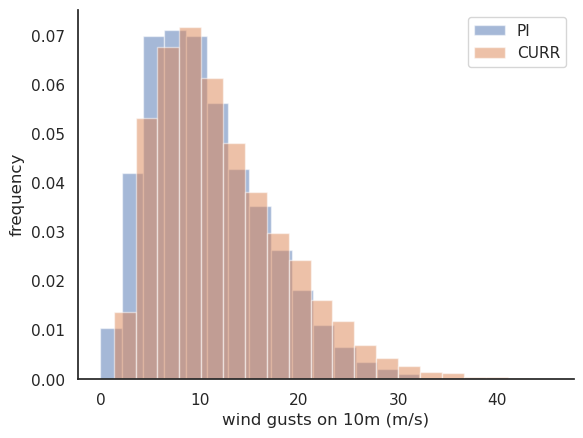

In [4]:
plt.hist(random.sample(wind_gusts_pi, 10000), alpha = 0.5, density = True, bins = 20, label = 'PI')
#plt.hist(random.sample(wind_gusts_incr, 10000), alpha = 0.5, density = True, bins = 20, label = 'INCR')
plt.hist(random.sample(wind_gusts_curr, 10000), alpha = 0.5, density = True, bins = 20, label = 'CURR')
plt.xlabel('wind gusts on 10m (m/s)')
plt.ylabel('frequency')
plt.legend()
sns.despine()


plt.savefig('figures/01_wind_gusts_hist.pdf')
plt.savefig('figures/01_wind_gusts_hist.png')

### Check statistical significance

In [5]:
print(stats.shapiro(random.sample(wind_gusts_pi, 1000)))  # Normality
print(stats.shapiro(random.sample(wind_gusts_curr, 1000)))
print(stats.levene(random.sample(wind_gusts_pi, 1000), random.sample(wind_gusts_curr, 1000)))  # Homogeneity of variance
print(stats.ttest_ind(random.sample(wind_gusts_pi, 1000), random.sample(wind_gusts_curr, 1000)))

ShapiroResult(statistic=0.9655171632766724, pvalue=1.2090590640755246e-14)
ShapiroResult(statistic=0.9388232231140137, pvalue=7.420091206761956e-20)
LeveneResult(statistic=1.562945211257467, pvalue=0.21138090772191628)
Ttest_indResult(statistic=-5.465021678629771, pvalue=5.2073236863550654e-08)


## Storm track